#  Predicting Stock Yields using NLP

Deep learning NLP techniques to map raw text to dense vector representations have had some surprising success in the world of computer natural language processing compared to classical means of encoding text. In this notebook we will attempt to leverage some of these techniques to help assist us in time series analysis on stock yields. We will be analyzing data from four different companies: Wells Fargo, JPMorgan Chase, Bank of America, and Citigroup, and the text data we will be leveraging are the SEC forms 8-K forms of these four banks. The 8-K form was chosen because it tends to be the more text rich SEC document when compared to others.

## Fetching Data

(Description of Data)

For this project we will need two data sources. Firstly we will need access to each stocks's historical price data. We will use an API to access this data. This gives us two options: Quandl's end of day stock price data API, or Alphavantage's end of day stock price, adjusted time series API. Since Quandl's API costs money we will use Alphavantage's API since its free. The second data source we need is access to each stock's published 8-K forms. For this data source we will web scrape the SEC's database: EDGAR, to gather the necessary data.

In [3]:
#!stockanalysis pull-data ../../test WFC JPM BAC C -f 10-k

## Exploratory Data Analysis

In [1]:
import os

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')

In [4]:
from stockanalysis.data import load_df

# Loading DataFrame from disk
df = load_df(path_to_data)

Checking if the DataFrame was loaded properly.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5031 entries, 0 to 5030
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   timestamp              5031 non-null   datetime64[ns]
 1   open_WFC               5031 non-null   float64       
 2   high_WFC               5031 non-null   float64       
 3   low_WFC                5031 non-null   float64       
 4   close_WFC              5031 non-null   float64       
 5   adjusted_close_WFC     5031 non-null   float64       
 6   volume_WFC             5031 non-null   float64       
 7   dividend_amount_WFC    5031 non-null   float64       
 8   split_coefficient_WFC  5031 non-null   float64       
 9   open_JPM               5031 non-null   float64       
 10  high_JPM               5031 non-null   float64       
 11  low_JPM                5031 non-null   float64       
 12  close_JPM              5031 non-null   float64       
 13  adj

Checking meta data of data set.

In [6]:
df.attrs

{'tickers': ['WFC', 'JPM', 'BAC', 'C'],
 'form_types': ['8-k'],
 'source': 'alphavantage',
 'path_to_data': '/media/Data/Programs/FinTech/data'}

In [7]:
tickers = df.attrs['tickers']

### Pricing Data

Checking some basic statistics of the dataset.

In [9]:
df[['_'.join(['adjusted_close', t]) for t in tickers]].describe()

,adjusted_close_WFC,adjusted_close_JPM,adjusted_close_BAC,adjusted_close_C
count,5031.000000,5031.000000,5031.000000,5031.000000
mean,28.466109,42.769751,21.351440,174.771051
std,13.482288,26.031430,9.760418,149.176072
min,6.276300,9.534400,2.831100,9.480500
25%,18.580600,26.027500,13.766300,44.343800
50%,23.314900,32.438100,19.427200,68.622900
75%,43.126300,51.375000,28.884400,333.506650
max,62.175200,124.790000,43.195000,474.080800


Plotting the time series of Adjusted Closing Price for each stock ticker

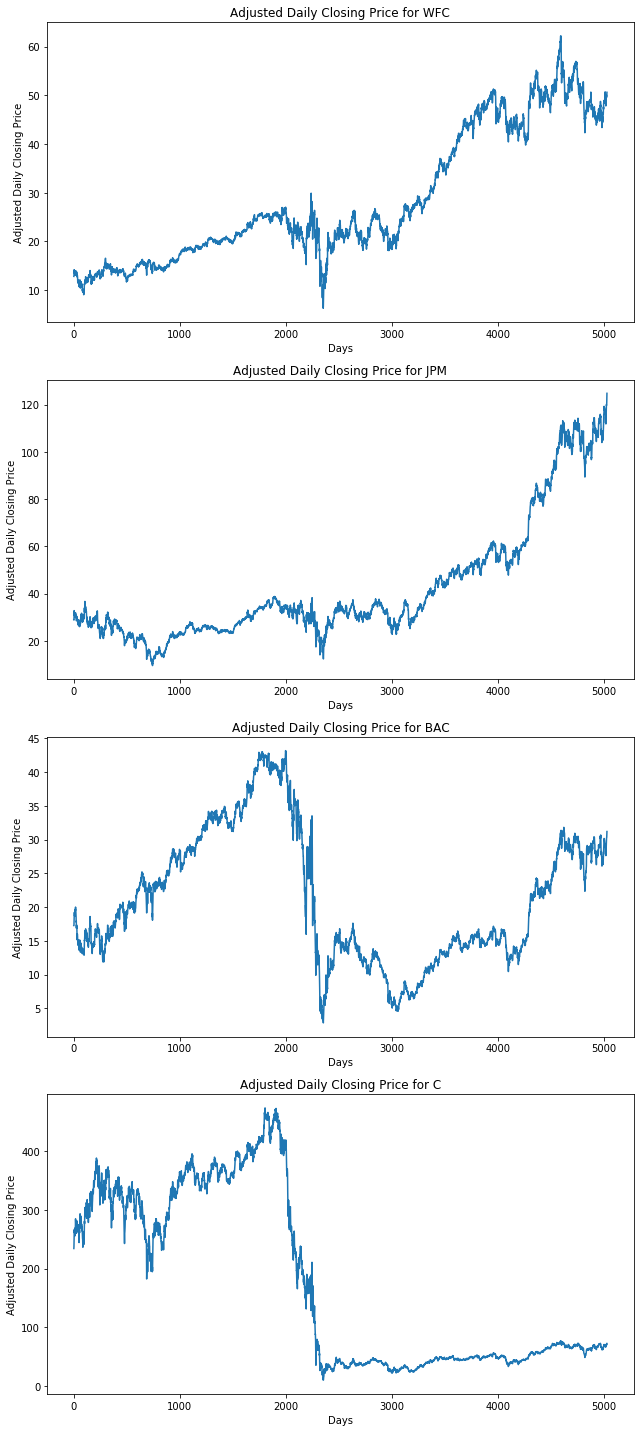

In [13]:
# Plotting Adjusted Daily Closing Price with respect to time.

import matplotlib.pyplot as plt

days = list(range(len(df)))

fig, ax = plt.subplots(len(tickers), 1, figsize=(9, 20), tight_layout=True)

for i in range(len(tickers)):
    t = tickers[i]
    adj_close_t = df.sort_values(by='timestamp', ascending=True)['_'.join(['adjusted_close', t])].tolist()
    
    ax[i].plot(days, adj_close_t)
    ax[i].set_title('Adjusted Daily Closing Price for {}'.format(t))
    ax[i].set_xlabel('Days')
    ax[i].set_ylabel('Adjusted Daily Closing Price')
    
plt.show()

It appears that there is an upward trend in all 4 stocks initially until about day 2300, then a sharp almost instaneous downward trend, followed by a slow upward trend until day 5000. These clear trends imply that the stochastic process generating the pricing data is not weakly stationary.

Plotting the distribution of Adjusted Closing Price across all time for each ticker. 

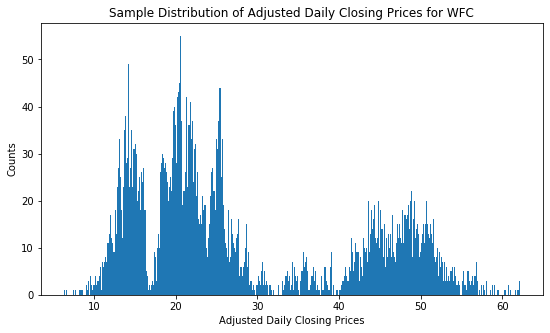

Statistics for Above Distribution
count    5027.000000
mean       28.448843
std        13.473737
min         6.276300
25%        18.571700
50%        23.301200
75%        43.080550
max        62.175200
Name: adjusted_close_WFC, dtype: float64



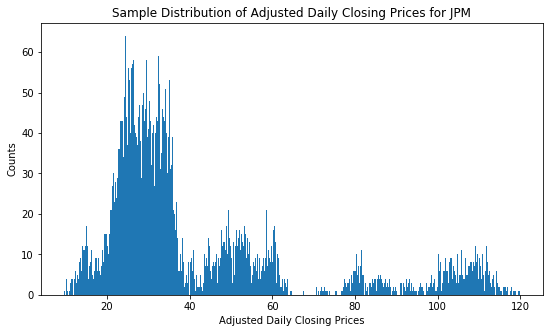

Statistics for Above Distribution
count    5027.000000
mean       42.706459
std        25.944793
min         9.534400
25%        26.025700
50%        32.426200
75%        51.336600
max       119.960000
Name: adjusted_close_JPM, dtype: float64



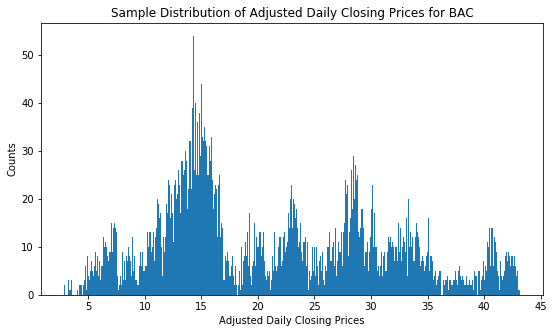

Statistics for Above Distribution
count    5027.000000
mean       21.343996
std         9.760724
min         2.831100
25%        13.766200
50%        19.341000
75%        28.870950
max        43.195000
Name: adjusted_close_BAC, dtype: float64



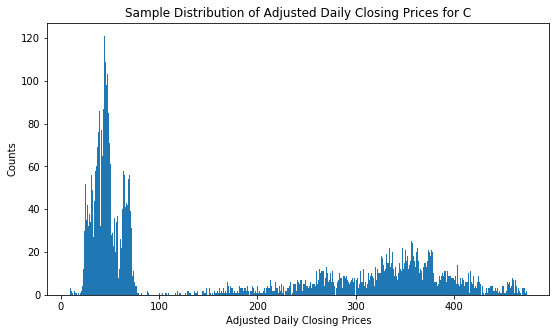

Statistics for Above Distribution
count    5027.000000
mean      174.853779
std       149.206569
min         9.480500
25%        44.341600
50%        68.616400
75%       333.589850
max       474.080800
Name: adjusted_close_C, dtype: float64



In [18]:
# Plotting the distribution of Adjusted Daily Closing Prices

import matplotlib.pyplot as plt

for i in range(len(tickers)):
    data = df['_'.join(['adjusted_close', tickers[i]])]
    fig, ax = plt.subplots(figsize=(9,5))
    ax.hist(data.tolist(), bins=500)
    ax.set_title('Sample Distribution of Adjusted Daily Closing Prices for {}'.format(tickers[i]))
    ax.set_xlabel('Adjusted Daily Closing Prices')
    ax.set_ylabel('Counts')
    plt.show()
    print('Statistics for Above Distribution')
    print(data.describe())
    print()

The distributions of Adjusted Daily Closing Prices for each ticker do not seem to conform to any specific type of distribution type.

It is a common assumption in financial modeling scenarios to assume that stock returns, are distributed according to a lognormal stochastic process dependent only on the difference between times of returns.

$R_{t\lambda} = \frac{S_{t}}{S_{t - \lambda}} \sim logN(\mu(\lambda), \sigma(\lambda))$

This implies that for fixed time differences, say considering only daily returns, then $R_{t} = R_{t\lambda=\lambda_{0}}$ is an iid (and stationary) stochastic process.

See: https://stats.stackexchange.com/questions/125761/why-stock-prices-are-lognormal-but-stock-returns-are-normal.

To check to see if this assumption can be applied to our dataset we will take the natural logarithm of our daily returns and see if the distribution is approximately Gaussian.

In [65]:
# Calculating the log adjusted closing prices, and log adjusted daily returns

import numpy as np

for t in tickers:
    df['_'.join(['log_adj_close', t])] = np.log(df['_'.join(['adjusted_close', t])])
    df['_'.join(['log_adj_daily_returns', t])] = df['_'.join(['log_adj_close', t])].shift(1) - df['_'.join(['log_adj_close', t])]
    df = df.dropna(subset=['_'.join(['log_adj_daily_returns', t])])

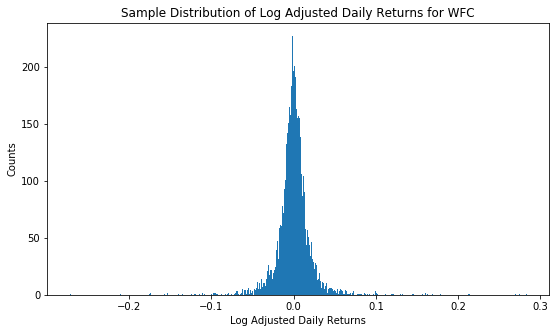

Statistics for Above Distribution
count    5023.000000
mean        0.000268
std         0.023499
min        -0.272103
25%        -0.007963
50%         0.000000
75%         0.008262
max         0.283404
Name: log_adj_daily_returns_WFC, dtype: float64



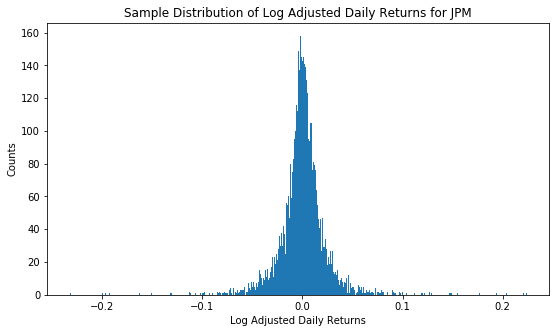

Statistics for Above Distribution
count    5023.000000
mean        0.000277
std         0.024247
min        -0.232277
25%        -0.008988
50%         0.000173
75%         0.009647
max         0.223916
Name: log_adj_daily_returns_JPM, dtype: float64



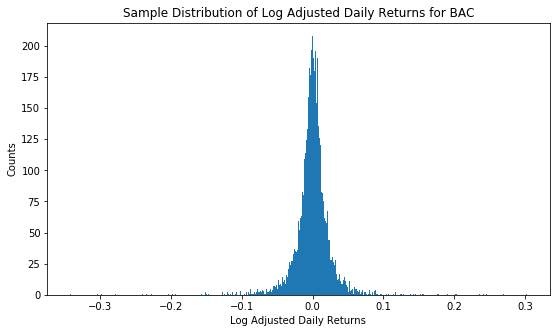

Statistics for Above Distribution
count    5023.000000
mean        0.000103
std         0.028755
min        -0.342067
25%        -0.009595
50%         0.000205
75%         0.009971
max         0.302101
Name: log_adj_daily_returns_BAC, dtype: float64



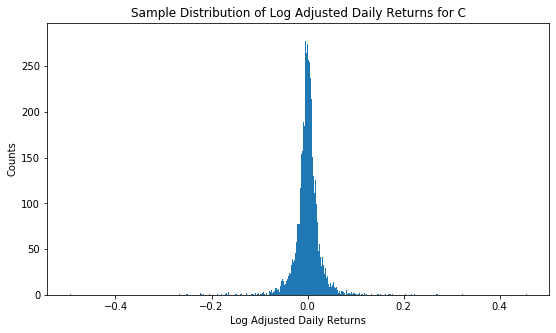

Statistics for Above Distribution
count    5023.000000
mean       -0.000240
std         0.030377
min        -0.494698
25%        -0.009880
50%         0.000000
75%         0.010000
max         0.456316
Name: log_adj_daily_returns_C, dtype: float64



In [69]:
# Plotting the distribution of Log Adjusted Daily Returns

import matplotlib.pyplot as plt

for i in range(len(tickers)):
    data = df['_'.join(['log_adj_daily_returns', tickers[i]])]
    fig, ax = plt.subplots(figsize=(9,5))
    ax.hist(data.tolist(), bins=500)
    ax.set_title('Sample Distribution of Log Adjusted Daily Returns for {}'.format(tickers[i]))
    ax.set_xlabel('Log Adjusted Daily Returns')
    ax.set_ylabel('Counts')
    plt.show()
    print('Statistics for Above Distribution')
    print(data.describe())
    print()

The above distributions for log daily returns appear to be Gaussian which suggests we may be able to leverage some of the assumptions of the aforementioned model.

Plotting the time series of log daily returns.

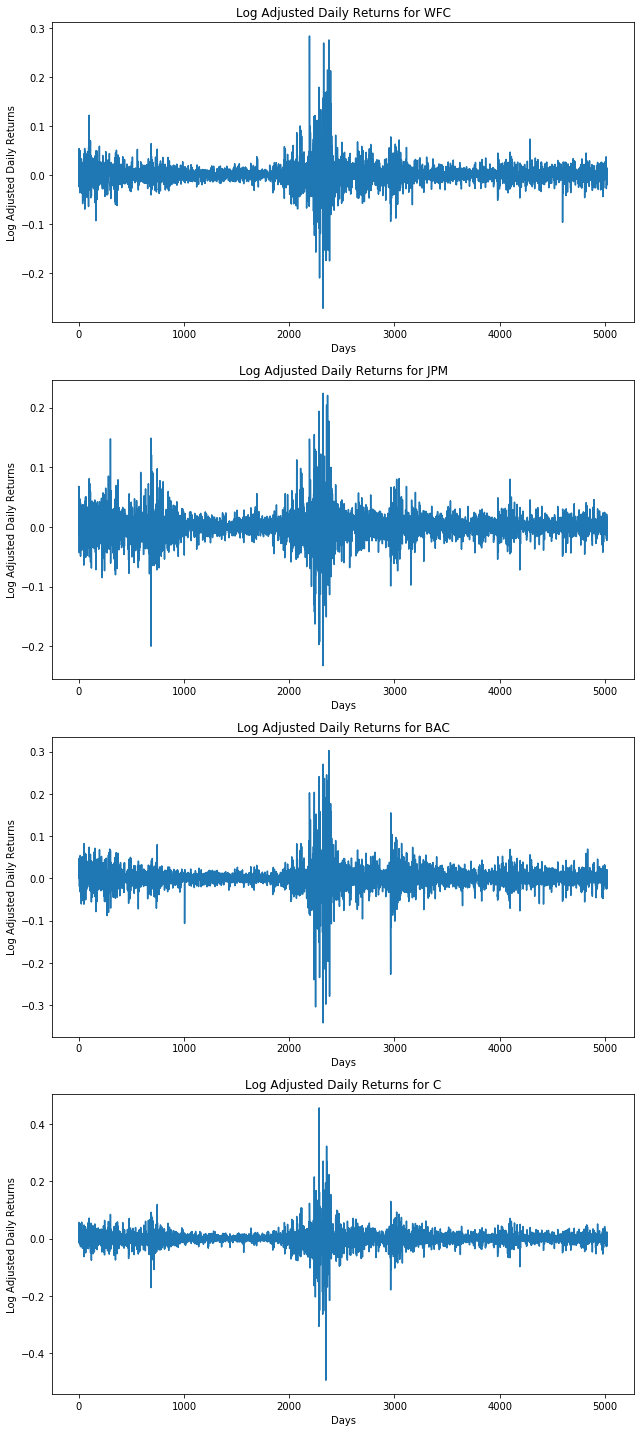

In [73]:
# Plotting Adjusted Daily Returns with respect to time

import matplotlib.pyplot as plt

days = list(range(len(df)))
fig, ax = plt.subplots(len(tickers), 1, figsize=(9, 20), tight_layout=True)

for i in range(len(tickers)):
    log_adj_daily_returns_t = df.sort_values(by='timestamp', ascending=True)['_'.join(['log_adj_daily_returns', tickers[i]])].tolist()
    ax[i].plot(days, log_adj_daily_returns_t)
    ax[i].set_title('Log Adjusted Daily Returns for {}'.format(tickers[i]))
    ax[i].set_xlabel('Days')
    ax[i].set_ylabel('Log Adjusted Daily Returns')
    
plt.show()

The above time series plots appear much more weakly stationary than the time series plots pre log and difference transformation (raw price time series plots)

Since we plan on training models that will be generalizable to these 4 bank stocks. We will now attempt to see if some of the above model assumptions can be applied to the entire dataset agnostic of stock choice.

Plotting the distribution of log daily returns for all stock tickers.

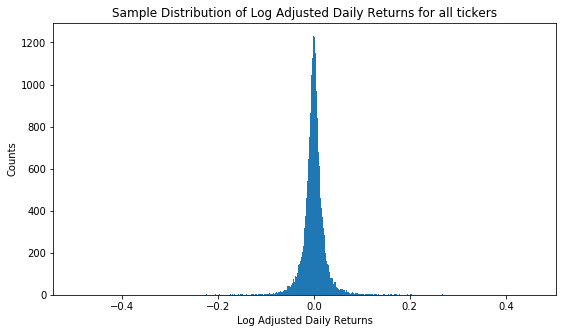

Statistics for Distribution
count    20092.000000
mean         0.000102
std          0.026877
min         -0.494698
25%         -0.009079
50%          0.000000
75%          0.009398
max          0.456316
dtype: float64


In [78]:
# Plotting the distribution of Log Adjusted Daily Returns for all Tickers

import pandas as pd
import matplotlib.pyplot as plt

data = []
for i in range(len(tickers)):
    data = data + df['_'.join(['log_adj_daily_returns', tickers[i]])].tolist()
data = pd.Series(data)

fig, ax = plt.subplots(figsize=(9,5))
ax.hist(data.tolist(), bins=500)
ax.set_title('Sample Distribution of Log Adjusted Daily Returns for all tickers')
ax.set_xlabel('Log Adjusted Daily Returns')
ax.set_ylabel('Counts')
plt.show()
print('Statistics for Distribution')
print(data.describe())

The log daily returns distribution for all stocks appears to be Gaussian as well. This makes sense when considering centrel limit theorems of sums of very similar random variables.

Plotting the log daily returns time series for all stock tickers.

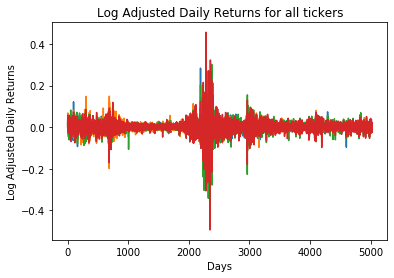

In [80]:
# Plotting Log Adjusted Daily Returns for all Tickers with respect to time

import matplotlib.pyplot as plt

days = list(range(len(df)))
fig, ax = plt.subplots()

for i in range(len(tickers)):
    log_adj_daily_returns_t = df.sort_values(by='timestamp', ascending=True)['_'.join(['log_adj_daily_returns', tickers[i]])].tolist()
    ax.plot(days, log_adj_daily_returns_t)

ax.set_title('Log Adjusted Daily Returns for all tickers')
ax.set_xlabel('Days')
ax.set_ylabel('Log Adjusted Daily Returns')
plt.show()

This time series also appears to be weakly stationary.

 *Conclusion*

The price time series' we are trying to model appear to be highly non-stationary. For deep learning models this isn't too much of an issue because the non-linearity of the model itself can account for the non-stationarity. The price we pay is in the bias of the statistical model itself. Although the function we may have learned has a low near-unbiased (assuming leave one out cross-validation) estimate of the functions error in prediction. The parameters of the learned statistical model itself will most likely not reflect their actual values. Again, if we only care about prediction error and we can stomach this downside, then non-linear models can give us a huge boost to the learned functions prediction error. Althought deep learning models can function perfectly well when trained on non-stationary data, making the data weakly stationary could provide a significant performance boost because the model will have an easier time learning from the weakly stationary data.

### Text Data

Investigating the lengths of our raw documents.

In [81]:
# Constructing doc_lengths: a list of lengths of all 8-K forms before they are normalized

import os

doc_lengths = []
doc_paths = []

for t in tickers:
    t_docs_path = os.path.join(path_to_data, 'documents', t)
    t_doclist = os.listdir(t_docs_path)
    for doc_name in t_doclist:
        doc_path = os.path.join(t_docs_path, doc_name)
        if os.path.isfile(doc_path):
            with open(doc_path, 'r') as f:
                raw_doc_text = f.read()
            doc_lengths.append(len(raw_doc_text))
            doc_paths.append(doc_path)
            

In [82]:
print("Largest document has: {} charcters".format(max(doc_lengths)))
print("Smallest document has: {} charcters".format(min(doc_lengths)))
largest_doc_path = doc_paths[doc_lengths.index(max(doc_lengths))]
smallest_doc_path = doc_paths[doc_lengths.index(min(doc_lengths))]

Largest document has: 125997383 charcters
Smallest document has: 3548 charcters


Plotting the distribution of raw document lengths.

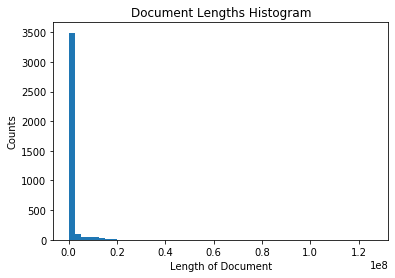

In [83]:
fig, ax = plt.subplots()
ax.hist(doc_lengths, bins=50)
ax.set_title('Document Lengths Histogram')
ax.set_xlabel('Length of Document')
ax.set_ylabel('Counts')
plt.show()

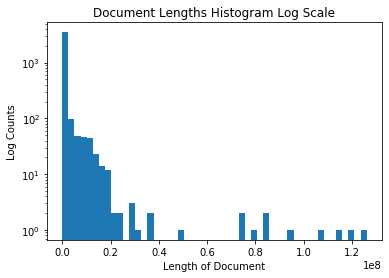

In [42]:
fig, ax = plt.subplots()
ax.hist(doc_lengths, bins=50, log=True)
ax.set_title('Document Lengths Histogram Log Scale')
ax.set_xlabel('Length of Document')
ax.set_ylabel('Log Counts')
plt.show()

From the above histograms, it appears very few of our documents contain over 30 million characters. Most of our documents seem to have 10 million characters or less with a large emphasize on documents with less than 1 million characters. Since a single characters is about 1 byte in memory, our largest document should be about 125 MB. Therefore we should expect all of our documents to be able to fit into our RAM of 32 GB

#### Text Normalizing

*(DESCRIBE NORMALIZATION PROCESS)*

To preprocess our text data, we will first strip it of its x/html tags if the data is encoded this way. Next we will un accent its accented characters, lower case the entire document, and replace all newline/carriage returns with spaces. Next we will strip it of its characters that are not alphanumeric, periods, dollar symbols, or percent symbols. Afterwards we will reduce all words to their dictionary lemmas, and strip the document of its stop words (see stop word list for spacy en_cor_web_sm model). Finally we will replace all whitespace characters with regular space characters, and drop words that are longer in length than a certian cutoff.

The structure of our 8-K filing document involves an xml SEC document header packed with metadata about the filing, and one or multiple xml `<DOCUMENT>` tags. These `<DOCUMENT>` tags contain different types of data that are bundled up into the complete submission for the 8-K filing. The data types stored in these `<DOCUMENT>` tags can range from everything including: regular text data such as html, to binary blob data such as jpg images and pdfs. The structure of these `<DOCUMENT>` tags involve a few meta data tags, none of which involve specifying the encoding type of the data that `<DOCUMENT>` tag stores, and a `<TEXT>` tag that stores the actual data.

Since the inclusion of binary blobs in the markdown prevents easy parsing of the filing structure with lxml, we will result to python re statements to extract the relevant `<DOCUMENT>` tags. Though because the meta data tags enclosed in a `<DOCUMENT>` tag do not specify the encoding type of the data enclosed in the `<TEXT>` tag, there does not appear to be an easy quick general solution that extracts the text data `<DOCUMENT>` tags and avoids the binary blob like `<DOCUMENT>` tags. Because of the above issues we will have to suffice ourselves with extracting only the `<DOCUMENT>` tag that contain's the meta data open tag `<TYPE>8-K`. This specific `<DOCUMENT>` tag always contains text data, and represents the data that is used to generate the SEC 8-K form containing the information that is mandated by the SEC, and excluding the exhibit information that is not mandated by the SEC and is given by the company's discretion. Since this `<DOCUMENT>` tag contains all the mandated information by the SEC for a given 8-K filing, we are still extracting the important information bundled in the filing even though we are not extracting all of the textual information.

Investigate the lengths of our normalized documents assuming no word length cut off.

In [84]:
# Constructing norm_doc_lengths: a list of lengths of all 8-K forms after they are normalized

import os
from stockanalysis.text_normalization_methods import normalize_document

norm_doc_lengths = []
norm_doc_paths = []

for t in tickers:
    t_docs_path = os.path.join(path_to_data, 'documents', t)
    t_doclist = os.listdir(t_docs_path)
    for doc_name in t_doclist:
        doc_path = os.path.join(t_docs_path, doc_name)
        if os.path.isfile(doc_path):
            with open(doc_path, 'r') as f:
                raw_doc_text = f.read()
            norm_doc_lengths.append(len(normalize_document(raw_doc_text)))
            norm_doc_paths.append(doc_path)

In [85]:
print("Largest document has: {} charcters".format(max(norm_doc_lengths)))
print("Smallest document has: {} charcters".format(min(norm_doc_lengths)))
largest_norm_doc_path = norm_doc_paths[norm_doc_lengths.index(max(norm_doc_lengths))]
smallest_norm_doc_path = norm_doc_paths[norm_doc_lengths.index(min(norm_doc_lengths))]

Largest document has: 610674 charcters
Smallest document has: 947 charcters


Plotting the distribution of normalized document lengths.

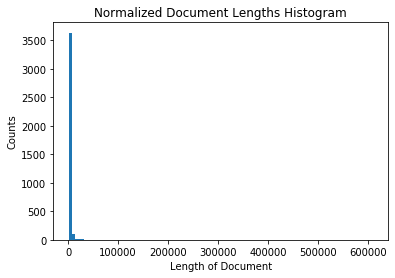

In [86]:
fig, ax = plt.subplots()
ax.hist(norm_doc_lengths, bins=100)
ax.set_title('Normalized Document Lengths Histogram')
ax.set_xlabel('Length of Document')
ax.set_ylabel('Counts')
plt.show()

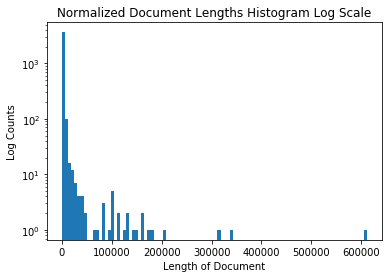

In [87]:
fig, ax = plt.subplots()
ax.hist(norm_doc_lengths, bins=100, log=True)
ax.set_title('Normalized Document Lengths Histogram Log Scale')
ax.set_xlabel('Length of Document')
ax.set_ylabel('Log Counts')
plt.show()

From the log scale distribution, its quite clear that there are very few normalized documents with over 200 thousand characters this is a big improvement over 30 million, and implies that our normalization procedures successfully shrinking the documents to more manageable lengths.

Investigating both the largest and smallest normalized documents.

In [88]:
# Checking Largest Normalized Document

with open(largest_norm_doc_path) as f:
    largest_norm_doc_raw = f.read()

largest_norm_doc = normalize_document(largest_norm_doc_raw, debug=True)
print()
print(largest_norm_doc_path)
print()
print(largest_norm_doc)

raw length of doc: 78927377
stripped tag length: 731646
altered accents length: 728747
lower casing length: 728747
removing newlines length: 728742
strip special char length: 705357
lemmatized doc length: 686438
removed stop word length: 559678
spaced num char length: 708948
large words removed char length: 708948
removed extra space length: 610674

/media/Data/Programs/FinTech/data/documents/JPM/0000019617-11-000266.txt

 exhibit 9 9 2 q 1 1 1 0 q item 1 2 exhibit 9 9 jpmorgan chase co . consolidate financial highlight unaudite million share headcount ratio datum month end june 3 0 as period end 2 q 1 1 1 q 1 1 4 q 1 0 3 q 1 0 2 q 1 0 2 0 1 1 2 0 1 0 selected income statement datum total net revenue $ 2 6 7 7 9 $ 2 5 2 2 1 $ 2 6 0 9 8 $ 2 3 8 2 4 $ 2 5 1 0 1 $ 5 2 0 0 0 $ 5 2 7 7 2 total noninter expense 1 6 8 4 2 1 5 9 9 5 1 6 0 4 3 1 4 3 9 8 1 4 6 3 1 3 2 8 3 7 3 0 7 5 5 preprovision profita 9 9 3 7 9 2 2 6 1 0 0 5 5 9 4 2 6 1 0 4 7 0 1 9 1 6 3 2 2 0 1 7 provision credit loss 1 8 1 

In [89]:
# Checking Smallest Normalized Document

with open(smallest_norm_doc_path, 'r') as f:
    smallest_norm_doc_raw = f.read()

smallest_norm_doc = normalize_document(smallest_norm_doc_raw, debug=True)
print()
print(smallest_norm_doc_path)
print()
print(smallest_norm_doc)

raw length of doc: 4158
stripped tag length: 2312
altered accents length: 2312
lower casing length: 2312
removing newlines length: 2289
strip special char length: 1876
lemmatized doc length: 1897
removed stop word length: 1765
spaced num char length: 1937
large words removed char length: 1937
removed extra space length: 947

/media/Data/Programs/FinTech/data/documents/C/0000950123-02-007241.txt

 u . s . security exchange commission washington d . c . 2 0 5 4 9 form 8 k current report pursuant section 1 3 1 5 d security exchange act 1 9 3 4 date report date early event report july 2 5 2 0 0 2 citigroup inc . exact registrant specify charter delaware 1 9 9 2 4 5 2 1 5 6 8 0 9 9 state commission irs employer jurisdiction file number identification . incorporation 3 9 9 park avenue new york new york 1 0 0 4 3 address principal executive office zip code 2 1 2 5 5 9 1 0 0 0 registrant telephone number include area code citigroup inc . current report form 8 k item 5 . event . july 2 5 2 0 0 

So far things look good. The relevant information of the 8-K Document sections seem to have not been cut out by our normalization procedures. The *Item #.##* sections are still existant in these normalized documents, thus they still contain the information that will be important for analysis, albiet with some noise still.

#### Normalized Vocabulary Analysis

Next we will investigate the vocabulary of our normalized 8-K Document corpus.

First we must create our vocab file and load it into a python object.

In [90]:
import os
from stockanalysis.text_normalization_methods import normalize_document
from stockanalysis.preprocess import append_vocab

norm_vocab = None

for t in tickers:
    t_docs_path = os.path.join(path_to_data, 'documents', t)
    t_doclist = os.listdir(t_docs_path)
    for doc_name in t_doclist:
        doc_path = os.path.join(t_docs_path, doc_name)
        if os.path.isfile(doc_path):
            with open(doc_path, 'r') as f:
                raw_doc_text = f.read()
            norm_doc = normalize_document(raw_doc_text)
            norm_vocab = append_vocab(norm_doc, 'test.json')

Let's view some of the words in our normalized vocabulary.

In [91]:
print(list(norm_vocab.keys()))

['wfc', '.', '4', 'q', 'er', '1', '2', '0', '5', 'form', '8', 'k', 'united', 'statessecuritie', 'exchange', 'commissionwashington', 'd', 'c', '9', 'kcurrent', 'reportpursuant', 'section', '3', 'ofthe', 'security', 'act', 'date', 'report', 'early', 'event', 'january', 'fargo', 'companyexact', 'registrant', 'specify', 'charter', 'delaware', '7', '6', 'state', 'jurisdictionof', 'incorporation', 'commission', 'filenumb', 'irs', 'employeridentification', 'no', 'montgomery', 'street', 'san', 'francisco', 'california', 'address', 'principal', 'executive', 'office', 'zip', 'code', 'telephone', 'number', 'include', 'area', 'codenot', 'applicableformer', 'change', 'reportcheck', 'appropriate', 'box', 'filing', 'intend', 'simultaneously', 'satisfy', 'obligation', 'follow', 'provision', 'write', 'communication', 'pursuant', 'rule', 'cfr', 'solicit', 'material', 'a', 'precommencement', 'b', 'e', 'citem', 'result', 'operation', 'financial', 'condition', 'on', 'company', 'issue', 'press', 'release', 

There appears to be a lot of nonsense words that seem like they could have come from either column names of tables included in the documents, or badly normalized urls. Removing such words from our documents would thus decrease the noise in our data source. Improving our normalization procedures could theoretically boost performance by making it easier for the model to learn patterns. One possible idea to improve the current normalization procedure could be to prescribe a test of some attribute of a word that is designed to flag most of these nonsense words, and if a word violates our test we remove it from the document.

A lot of these nonsense words also appear to be very long in character length, which implies we might test for nonsense words by testing for word length. Lets analyze the distribution of word length and see if we can choose a cut off for word length that captures most of these nonsense words.

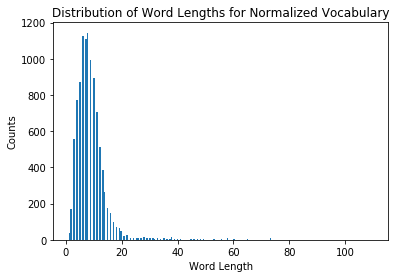

In [92]:
word_lens = list(map(len, norm_vocab.keys()))
fig, ax = plt.subplots()
ax.hist(word_lens, bins=200)
ax.set_title('Distribution of Word Lengths for Normalized Vocabulary')
ax.set_xlabel('Word Length')
ax.set_ylabel('Counts')
plt.show()

It appears that there are very few words with character lengths over 20 characters. This implies that if we choose our cut off to be about 20 characters or more, we should not be removing too many words that actually contribute to valuable information.

Testing a few word cut off lengths.

In [96]:
cut_off = 20
words_greater_than = [word for word in norm_vocab.keys() if cut_off <= len(word)]
print(words_greater_than)

['commissionwashington', 'employeridentification', 'jurisdictioncommission', 'incorporationnumberidentification', 'multiplepointofentry', 'herewithsignaturepursuant', 'wfccommonstockparvalue', 'wfcnoncumulativeperpetualconvertibleclasspreferredstockserieslmember', 'wfcdepositaryshareseachrepresenting', 'thinterestinshareofnoncumulativeperpetualclasspreferredstockseriesnmember', 'thinterestinshareofnoncumulativeperpetualclasspreferredstockseriesomember', 'thinterestinshareofnoncumulativeperpetualclasspreferredstockseriespmember', 'fixedtofloatingratenoncumulativeperpetualclasspreferredstockseriesqmember', 'fixedtofloatingratenoncumulativeperpetualclasspreferredstockseriesrmember', 'thinterestinshareofnoncumulativeperpetualclasspreferredstockseriestmember', 'thinterestinshareofnoncumulativeperpetualclasspreferredstockseriesvmember', 'thinterestinshareofnoncumulativeperpetualclasspreferredstockserieswmember', 'thinterestinshareofnoncumulativeperpetualclasspreferredstockseriesxmember', 'th

In [97]:
cut_off = 18
words_greater_than = [word for word in norm_vocab.keys() if cut_off <= len(word)]
print(words_greater_than)

['commissionwashington', 'employeridentification', 'signaturespursuant', 'jurisdictioncommission', 'incorporationnumberidentification', 'descriptionlocation', 'multiplepointofentry', 'singlepointofentry', 'herewithsignaturepursuant', 'wfccommonstockparvalue', 'wfcnoncumulativeperpetualconvertibleclasspreferredstockserieslmember', 'wfcdepositaryshareseachrepresenting', 'thinterestinshareofnoncumulativeperpetualclasspreferredstockseriesnmember', 'thinterestinshareofnoncumulativeperpetualclasspreferredstockseriesomember', 'thinterestinshareofnoncumulativeperpetualclasspreferredstockseriespmember', 'thinterestinshareof', 'fixedtofloatingratenoncumulativeperpetualclasspreferredstockseriesqmember', 'fixedtofloatingratenoncumulativeperpetualclasspreferredstockseriesrmember', 'thinterestinshareofnoncumulativeperpetualclasspreferredstockseriestmember', 'thinterestinshareofnoncumulativeperpetualclasspreferredstockseriesvmember', 'thinterestinshareofnoncumulativeperpetualclasspreferredstockseries

In [98]:
cut_off = 16
words_greater_than = [word for word in norm_vocab.keys() if cut_off <= len(word)]
print(words_greater_than)

['commissionwashington', 'employeridentification', 'applicableformer', 'signaturespursuant', 'transitionrelated', 'jurisdictioncommission', 'incorporationnumberidentification', 'descriptionlocation', 'signaturepursuant', 'secretaryexhibit', 'multiplepointofentry', 'singlepointofentry', 'herewithsignaturepursuant', 'conditionattached', 'reclassification', 'wfccommonstockparvalue', 'wfcnoncumulativeperpetualconvertibleclasspreferredstockserieslmember', 'wfcdepositaryshareseachrepresenting', 'thinterestinshareofnoncumulativeperpetualclasspreferredstockseriesnmember', 'thinterestinshareofnoncumulativeperpetualclasspreferredstockseriesomember', 'thinterestinshareofnoncumulativeperpetualclasspreferredstockseriespmember', 'thinterestinshareof', 'fixedtofloatingratenoncumulativeperpetualclasspreferredstockseriesqmember', 'fixedtofloatingratenoncumulativeperpetualclasspreferredstockseriesrmember', 'thinterestinshareofnoncumulativeperpetualclasspreferredstockseriestmember', 'thinterestinshareofn

From the above inspection real words like: 'undercapitalized' are captured in the 16 character length cutoff while most real words are not captured in the other cutoffs. This implies that we should use a cutoff of 18 characters or more because it is the largest cutoff that captures the least amount of real words.

*Conclusion*

From our exploratory analysis of the raw dataset we can conclude that our pricing data seems to fit the assumptions one usually assumes about stock pricing data. This means that the stock pricing data should be distributed log-normally and implies that the log returns of a stock over a period of time should be distributed normally. Our exploratory analysis of our text data shows there is nothing unusual about our raw text data, and it should fit into memory fine. It also shows that our text preprocessing methods still preserve the important parts of our text data and thus should not pose a future issue for analysis. From these findings we can conclude that our raw text data is useable, our text preprocessing methods are useable, and our price data is useable. Since the log returns of our pricing data (Adjusted Daily Closing Price) appear to fit a Gaussian distribution pretty well, our predictor variable in analysis should be log returns (as opposed to Adjusted Daily Closing Price) because the Gaussian distribution has some nice mathematical properties that might be leveraged further on in the future.

## Preprocessing Data

### Preprocessing process 1

*(Explain preprocessing process)*

In [1]:
import os

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')

In [2]:
# Loading DataFrame
from stockanalysis.data import load_df

df = load_df(path_to_data)

Checking if the raw DataFrame was reloaded properly.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5031 entries, 0 to 5030
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   timestamp              5031 non-null   datetime64[ns]
 1   open_WFC               5031 non-null   float64       
 2   high_WFC               5031 non-null   float64       
 3   low_WFC                5031 non-null   float64       
 4   close_WFC              5031 non-null   float64       
 5   adjusted_close_WFC     5031 non-null   float64       
 6   volume_WFC             5031 non-null   float64       
 7   dividend_amount_WFC    5031 non-null   float64       
 8   split_coefficient_WFC  5031 non-null   float64       
 9   open_JPM               5031 non-null   float64       
 10  high_JPM               5031 non-null   float64       
 11  low_JPM                5031 non-null   float64       
 12  close_JPM              5031 non-null   float64       
 13  adj

In [4]:
df.attrs

{'tickers': ['WFC', 'JPM', 'BAC', 'C'],
 'form_types': ['8-k'],
 'source': 'alphavantage',
 'path_to_data': '/media/Data/Programs/FinTech/data'}

Setting up the parameters needed for preprocessing the dataset.

In [5]:
# Dataset Sizes
train_size = 0.6
val_size = 0.2
test_size = 0.2

# Tickers to preprocess
tickers = df.attrs['tickers']

# Word cut off for text normalization procedures
cut_off = 18

# Number of time series lag-variables to include as features
window_size = 5

# Random seed
seed = 42

Splitting the data set into train, validation, and test datasets while preserving the dataset's temporal structure.

In [51]:
def time_series_split(df, train_size=None, test_size=None):
    """
    Splits the dataset into train, validation, and test portions.
    
    :param df: pandas.DataFrame, representing our total dataset
    :param train_size: float, training set size
    :param test_size: float, test set size
    
    ---> pandas.DataFrame, pandas.DataFrame, pandas.DataFrame, representing the train, validation, test datasets
    """
    
    dataset_size = len(df)
    
    if test_size != None:
        testset_index = int(test_size*dataset_size)
    elif train_size != None:
        testset_index = int((1 - train_size)*dataset_size)
    else:
        raise Exception('train_size and or test_size needs to be set')
    
    test_df = df.iloc[0:testset_index].copy(deep=True)
    train_df = df.iloc[testset_index:].copy(deep=True)
    
    return train_df, test_df

In [52]:
df_full_train, df_test = time_series_split(df, test_size=test_size)
df_train, df_val = time_series_split(df_full_train, test_size=(val_size / (val_size + train_size)))

Preprocessing the training, validation, test, and full training datasets.

In [53]:
from stockanalysis.preprocess import preprocess

(X_train, y_train), vocab_train = preprocess(df_train, tickers, cut_off, None, window_size, seed, norm_dirname='norm_train', encode_dirname='encode_train')
(X_val, y_val), _ = preprocess(df_val, tickers, cut_off, vocab_train, window_size, seed, norm_dirname='norm_train', encode_dirname='encode_train')
(X_full_train, y_full_train), vocab_full_train = preprocess(df_full_train, tickers, cut_off, None, window_size, seed, norm_dirname='norm_full_train', encode_dirname='encode_full_train')
(X_test, y_test), _ = preprocess(df_test, tickers, cut_off, vocab_full_train, window_size, seed, norm_dirname='norm_full_train', encode_dirname='encode_full_train')

Saving our datasets to disk.

In [55]:
import pickle

with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'wb') as f:
    pickle.dump((X_train, y_train), f, protocol=4)

In [56]:
import pickle

with open(os.path.join(path_to_data, 'val_dataset.pickle'), 'wb') as f:
    pickle.dump((X_val, y_val), f, protocol=4)

In [57]:
import pickle

with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'wb') as f:
    pickle.dump((X_test, y_test), f, protocol=4)

In [58]:
import pickle

with open(os.path.join(path_to_data, 'full_train_dataset.pickle'), 'wb') as f:
    pickle.dump((X_full_train, y_full_train), f, protocol=4)

### Preprocessing process 2

In [1]:
import os

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')

In [2]:
# Loading DataFrame
from stockanalysis.data import load_df

df = load_df(path_to_data)

Checking if the raw DataFrame was reloaded properly.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5031 entries, 0 to 5030
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   timestamp              5031 non-null   datetime64[ns]
 1   open_WFC               5031 non-null   float64       
 2   high_WFC               5031 non-null   float64       
 3   low_WFC                5031 non-null   float64       
 4   close_WFC              5031 non-null   float64       
 5   adjusted_close_WFC     5031 non-null   float64       
 6   volume_WFC             5031 non-null   float64       
 7   dividend_amount_WFC    5031 non-null   float64       
 8   split_coefficient_WFC  5031 non-null   float64       
 9   open_JPM               5031 non-null   float64       
 10  high_JPM               5031 non-null   float64       
 11  low_JPM                5031 non-null   float64       
 12  close_JPM              5031 non-null   float64       
 13  adj

In [4]:
df.attrs

{'tickers': ['WFC', 'JPM', 'BAC', 'C'],
 'form_types': ['8-k'],
 'source': 'alphavantage',
 'path_to_data': '/media/Data/Programs/FinTech/data'}

Setting up the parameters needed for preprocessing the dataset.

In [5]:
# Dataset Sizes
train_size = 0.6
val_size = 0.2
test_size = 0.2

# Tickers to preprocess
tickers = df.attrs['tickers']

# Word cut off for text normalization procedures
cut_off = 18

# Number of time series lag-variables to include as features
window_size = 5

# Random seed
seed = 42

Splitting the data set into train, validation, and test datasets while preserving the dataset's temporal structure.

In [6]:
def time_series_split(df, train_size=None, test_size=None):
    """
    Splits the dataset into train, validation, and test portions.
    
    :param df: pandas.DataFrame, representing our total dataset
    :param train_size: float, training set size
    :param test_size: float, test set size
    
    ---> pandas.DataFrame, pandas.DataFrame, pandas.DataFrame, representing the train, validation, test datasets
    """
    
    dataset_size = len(df)
    
    if test_size != None:
        testset_index = int(test_size*dataset_size)
    elif train_size != None:
        testset_index = int((1 - train_size)*dataset_size)
    else:
        raise Exception('train_size and or test_size needs to be set')
    
    test_df = df.iloc[0:testset_index].copy(deep=True)
    train_df = df.iloc[testset_index:].copy(deep=True)
    
    return train_df, test_df

In [7]:
df_full_train, df_test = time_series_split(df, test_size=test_size)
df_train, df_val = time_series_split(df_full_train, test_size=(val_size / (val_size + train_size)))

Preprocessing the training, validation, test, and full training datasets. Using preprocess2.

In [8]:
from stockanalysis.preprocess import preprocess2

(X_train, y_train), vocab_train = preprocess2(df_train, tickers, cut_off, None, window_size, seed, norm_dirname='norm_trainp2', encode_dirname='encode_trainp2')
(X_val, y_val), _ = preprocess2(df_val, tickers, cut_off, vocab_train, window_size, seed, norm_dirname='norm_trainp2', encode_dirname='encode_trainp2')
(X_full_train, y_full_train), vocab_full_train = preprocess2(df_full_train, tickers, cut_off, None, window_size, seed, norm_dirname='norm_full_trainp2', encode_dirname='encode_full_trainp2')
(X_test, y_test), _ = preprocess2(df_test, tickers, cut_off, vocab_full_train, window_size, seed, norm_dirname='norm_full_trainp2', encode_dirname='encode_full_trainp2')

Saving our datasets to disk.

In [9]:
import pickle

with open(os.path.join(path_to_data, 'train_datasetp2.pickle'), 'wb') as f:
    pickle.dump((X_train, y_train), f, protocol=4)

In [10]:
import pickle

with open(os.path.join(path_to_data, 'val_datasetp2.pickle'), 'wb') as f:
    pickle.dump((X_val, y_val), f, protocol=4)

In [11]:
import pickle

with open(os.path.join(path_to_data, 'test_datasetp2.pickle'), 'wb') as f:
    pickle.dump((X_test, y_test), f, protocol=4)

In [12]:
import pickle

with open(os.path.join(path_to_data, 'full_train_datasetp2.pickle'), 'wb') as f:
    pickle.dump((X_full_train, y_full_train), f, protocol=4)

# CODE FOR TESTING

The first thing we will need to confirm is if the re's we constructed for extracting a documents 8-K component, and the html tag (if they exist) works/still works. For the time being the data we will use from each document will only be the text embedded in the 8-K component of the document.

In [25]:
# Checking the extract_8k function
checksout = True
for t in tickers:
    t_docs_path = os.path.join(path_to_docs, t)
    t_doclist = os.listdir(t_docs_path)
    if 'normalized' in t_doclist:
        t_doclist.remove('normalized')
    if 'norm_test' in t_doclist:
        t_doclist.remove('norm_test')
    for doc_name in t_doclist:
        doc_path = os.path.join(t_docs_path, doc_name)
        with open(doc_path, 'r') as f:
            raw_doc_text = f.read()
        num_of_8k = len(text_norm.extract_8k(raw_doc_text))
        if num_of_8k != 1:
            checksout = False
            print('Filing: {0}, contains: {1} 8-K portions, check re of extract_8k, and document.'.format(doc_path, num_of_8k))

if checksout:
    print('The re in extract_8k seems to checkout.')

The re in extract_8k seems to checkout.


In [46]:
# Checking the extract_html function
checksout = True
for t in tickers:
    t_docs_path = os.path.join(path_to_docs, t)
    t_doclist = os.listdir(t_docs_path)
    if 'normalized' in t_doclist:
        t_doclist.remove('normalized')
    for doc_name in t_doclist:
        doc_path = os.path.join(t_docs_path, doc_name)
        with open(doc_path, 'r') as f:
            raw_doc_text = f.read()
        eight_k = text_norm.extract_8k(raw_doc_text)[0]
        num_html_tags = len(text_norm.extract_html(eight_k))
        if not (0 <= num_html_tags <= 1):
            checksout = False
            print('Filing: {0}, contains: {1} html tags, check re of extract_html, and document.'.format(doc_path, num_html_tags))

if checksout:
    print('The re in extract_html seems to checkout.')

The re in extract_html seems to checkout.


In each 8-K filing there should be only one `<DOCUMENT>...</DOCUMENT>` tag that contains a:`<TYPE>8-K` tag. There should also be ONLY one `<html ...>...</html>` tag if the document tag contains an html tag. The above cells verify if any of these conditions are violated on the current dataset.

# NOT TEST

In [37]:
# samples randomly from each samples 8-k docs across all tickers

import numpy as np

tickers = ['WFC', 'JPM', 'C', 'BAC']
fname = '8-k'
seed = None

np.random.seed(seed)
features = ds[0]

features[fname] = []

for i in range(len(features['_'.join([fname, tickers[0]])])):
    samples_docs = [features['_'.join([fname, t])][i] for t in tickers if features['_'.join([fname, t])][i].shape[0] != 0]
    doc_index = np.random.choice(len(samples_docs), size=1)[0]
    sample_doc = samples_docs[doc_index]
    features[fname].append(sample_doc)
    
for t in tickers:
    del features['_'.join([fname, t])]